In [20]:
from typing_extensions import TypedDict, Literal
from pydantic import BaseModel, Field

In [21]:
from langchain_ollama import ChatOllama
from langchain_core.messages import SystemMessage, HumanMessage
llm = ChatOllama(model="llama3.1:latest", temperature=0)


In [22]:
class Route(BaseModel):
    type:Literal["support", "tech", "important"] = Field(None, description="the next step in the routing process")

In [23]:
router = llm.with_structured_output(Route)

In [24]:
class State(TypedDict):
    input:str
    output:str
    decision:str

In [25]:
def tech_team(state:State):
    """give reply from tech team"""
    result = llm.invoke(state["input"])
    return {"output":result.content}

In [26]:
def support_team(state:State):
    """give reply from support team"""
    result = llm.invoke(state["input"])
    return {"output":result.content}

In [27]:
def manager_team(state:State):
    """give reply from manager"""
    result = llm.invoke(state["input"])
    return {"output":result.content}

In [28]:
def llm_router(state:State):
    """Route the input to the appropriate node"""

    decision = router.invoke(
        [
            SystemMessage(content="Route the input to tech , support or important based on the user request"),
            HumanMessage(content=state["input"])
        ]
    )

    return {"decision":decision.type}

In [29]:
def conditional_edge(state:State):
    if state['decision']== "tech":
        return "tech_team"
    if state['decision']== "support":
        return "support_team"
    if state['decision']== "important":
        return "manager_team"

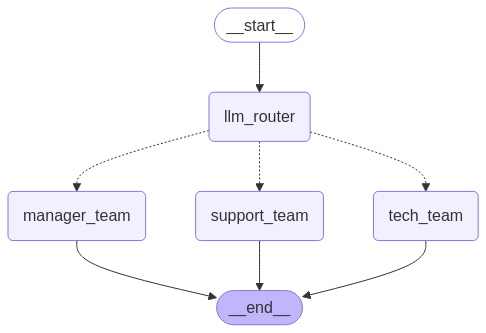

In [30]:
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display

email_agent = StateGraph(State)

email_agent.add_node("tech_team", tech_team)
email_agent.add_node("support_team", support_team)
email_agent.add_node("manager_team", manager_team)
email_agent.add_node("llm_router", llm_router)

email_agent.add_edge(START, "llm_router")
email_agent.add_conditional_edges("llm_router",conditional_edge, {"tech_team":"tech_team","support_team":"support_team", "manager_team":"manager_team" } )
email_agent.add_edge("tech_team", END)
email_agent.add_edge("support_team", END)
email_agent.add_edge("manager_team", END)

email_agent = email_agent.compile()
display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))


In [ ]:
state = email_agent.invoke({"input":"hi i am facing issue in ticket booking"})
state